In [1]:
from collections import defaultdict
import gym
import numpy as np
import matplotlib.pyplot as plt

In [5]:
NUM_EXPERIMENTS_DEFAULT = 100000

# Часть первая, стандартная

In [2]:
env = gym.make('Blackjack-v0', natural=False)

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко

In [3]:
def play_simple_strategy(env):
    observation = env.reset()
    while True:
        hand, dealer_hand, usable_ace = observation
        if hand < 19:
            observation, reward, done, info = env.step(1)
        else:
            observation, reward, done, info = env.step(0)
        if done:
            return reward

Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [4]:
total_reward = []
for _ in range(NUM_EXPERIMENTS_DEFAULT):
    env.reset()
    reward = play_simple_strategy(env)
    total_reward.append(reward)
env.close()

print("Средняя награда: %.6f" % np.mean(total_reward))
print("Доля выигрышей: %.6f" % np.mean(np.array(total_reward) > 0))
print("Сумма выигрышей: %.1f" % np.sum(total_reward))

Средняя награда: -0.207100
Доля выигрышей: 0.358500
Сумма выигрышей: -2071.0


### Функции для игры по заданным стратегиям

In [6]:
def to_index(S):
    return tuple(int(x) for x in S)

In [7]:
def play_with_strategy(env, pi, smooth):
    """Играем один эпизод по стратегии pi в режиме exploration"""
    Ss = []
    As = []
    Rs = []
    observation = env.reset()
    action = env.action_space.sample()
    done = False
    while not done:
        Ss.append(observation)
        observation, reward, done, info = env.step(action)
        As.append(action)
        Rs.append(reward)
        if smooth:
            ps = pi[to_index(observation)]
            action = env.np_random.choice(np.arange(env.action_space.n), p = ps / ps.sum())
        else:
            action = pi[to_index(observation)]
    return Ss, As, Rs

In [8]:
def play_with_strategy_on_policy(env, pi):
    """Играем один эпизод по стратегии pi в режиме exploitation"""
    observation = env.reset()
    while True:
        action = pi[to_index(observation)]
        observation, reward, done, info = env.step(action)
        if done:
            return reward

In [9]:
def play_with_strategy_on_policy_smooth(env, pi):
    """Играем один эпизод по мягкой стратегии pi в режиме exploitation"""
    observation = env.reset()
    while True:
        ps = pi[to_index(observation)]
        action = env.np_random.choice(np.arange(env.action_space.n), p = ps / ps.sum())
        observation, reward, done, info = env.step(action)
        if done:
            return reward

In [10]:
def check_strategy(env, pi, smooth, num_experiments=NUM_EXPERIMENTS_DEFAULT):
    """Играем много эпизодов по стратегии pi в режиме exploitation и возвращаем список наград за каждую игру"""
    total_reward = []

    for _ in range(num_experiments):
        env.reset()
        if smooth:
            reward = play_with_strategy_on_policy_smooth(env, pi)
        else:
            reward = play_with_strategy_on_policy(env, pi)
        total_reward.append(reward)
    env.close()

    print("Средняя награда: %.6f" % np.mean(total_reward))
    print("Доля выигрышей: %.6f" % np.mean(np.array(total_reward) > 0))
    print("Сумма выигрышей: %.1f" % np.sum(total_reward))
    avg_reward = np.cumsum(total_reward) / np.arange(1, len(total_reward) + 1)
    return avg_reward

*Реализуйте метод обучения с подкреплением без модели*

Реализовано:
- Алгоритм Monte Carlo control with exploring starts
- Алгоритм on-policy Monte Carlo control с мягкими стратегиями
- Алгоритм off-policy Monte Carlo control
- Алгоритм Q-learning (off-policy TD control)

### Алгоритм Monte Carlo control with exploring starts

In [11]:
def monte_carlo_estimation(env, pi, gamma = 0.5, num_experiments = NUM_EXPERIMENTS_DEFAULT):
    RetS = defaultdict(list)
    Q = env.np_random.rand(*(x.n for x in env.observation_space), env.action_space.n) - 1
    
    for _ in range(num_experiments):
        Ss, As, Rs = play_with_strategy(env, pi, smooth=False)
        G = 0
        for t in list(range(0, len(Ss)))[::-1]:
            St, At, Rt = Ss[t], As[t], Rs[t]
            G = gamma * G + Rt
            RetS[(St, At)].append(G)
            Q[(*to_index(St), At)] = np.mean(RetS[(St, At)])
            pi[to_index(St)] = Q[to_index(St)].argmax()
    return RetS, Q

Инициализация и прогон случайной стратегии

In [12]:
pi_random = np.random.randint(2, size=[x.n for x in env.observation_space])
avg_reward_random = check_strategy(env, pi_random, smooth=False)

Средняя награда: -0.388660
Доля выигрышей: 0.282640
Сумма выигрышей: -38866.0


Инициализация и прогон стратегии из п.1 ("stand" on >=19)

In [13]:
pi_stable = np.ones([x.n for x in env.observation_space], dtype=int)
pi_stable[19:,:,:] = 0
avg_reward_stable = check_strategy(env, pi_stable, smooth=False)

Средняя награда: -0.199780
Доля выигрышей: 0.362080
Сумма выигрышей: -19978.0


Построение и прогон стратегии monte_carlo_estimation (основано на стратегии из п.1)

In [14]:
pi = pi_stable.copy()
RetS, Q = monte_carlo_estimation(env, pi, gamma = 0.9)

In [15]:
avg_reward = check_strategy(env, pi, smooth=False)

Средняя награда: -0.051170
Доля выигрышей: 0.430650
Сумма выигрышей: -5117.0


/Users/aleksei/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/aleksei/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


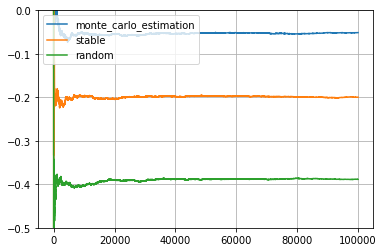

In [16]:
plt.plot(avg_reward, label="monte_carlo_estimation")
plt.plot(avg_reward_stable, label="stable")
plt.plot(avg_reward_random, label="random")
plt.ylim([-0.5, 0])
plt.grid()
_ = plt.legend()

### Алгоритм on-policy Monte Carlo control с мягкими стратегиями

In [17]:
def monte_carlo_control_smooth(env, pi,eps=0.5,  num_experiments = NUM_EXPERIMENTS_DEFAULT):
    RetS = defaultdict(list)
    gamma = 0.5
    Q = np.random.rand(*(x.n for x in env.observation_space), 2) * 2 - 1
    
    for _ in range(num_experiments):
        Ss, As, Rs = play_with_strategy(env, pi, smooth=True)
        G = 0
        for t in list(range(0, len(Ss)))[::-1]:
            St, At, Rt = Ss[t], As[t], Rs[t]
            G = gamma * G + Rt
            RetS[(St, At)].append(G)
            Q[(*to_index(St), At)] = np.mean(RetS[(St, At)])
            a_star = Q[to_index(St)].argmax()
            ps = np.ones(env.action_space.n) * eps / env.action_space.n
            ps[a_star] = 1 - eps + eps / env.action_space.n
            pi[to_index(St)] = ps
    return RetS, Q

Инициализация и прогон "равномерной" мягкой стратегии

In [18]:
pi = np.ones((*(x.n for x in env.observation_space), env.action_space.n))
pi = (pi.T / pi.T.sum(axis=0)).T

In [19]:
avg_reward_random_smooth = check_strategy(env, pi, smooth=True)

Средняя награда: -0.399660
Доля выигрышей: 0.278530
Сумма выигрышей: -39966.0


Построение стратегии monte_carlo_control_smooth (основано на  "равномерной" мягкой стратегии)

In [20]:
RetS, Q = monte_carlo_control_smooth(env, pi, eps=0.1)

Прогон стратегии monte_carlo_control_smooth в мягком режиме (стохастической)

In [21]:
avg_reward_smooth = check_strategy(env, pi, smooth=True)

Средняя награда: -0.086740
Доля выигрышей: 0.413570
Сумма выигрышей: -8674.0


Прогон стратегии monte_carlo_control_smooth в жестком режиме (детерминированной)

In [22]:
avg_reward_hard = check_strategy(env, pi.argmax(axis=-1), smooth=False)

Средняя награда: -0.050210
Доля выигрышей: 0.430980
Сумма выигрышей: -5021.0


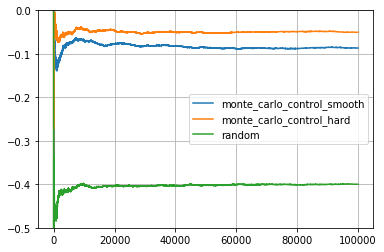

In [23]:
plt.plot(avg_reward_smooth, label="monte_carlo_control_smooth")
plt.plot(avg_reward_hard, label="monte_carlo_control_hard")
plt.plot(avg_reward_random_smooth, label="random")
plt.ylim([-0.5, 0])
plt.grid()
_ = plt.legend()

### Алгоритм off-policy Monte Carlo control

In [24]:
def monte_carlo_control_off_policy(env, b, pi, eps=0.5, num_experiments = NUM_EXPERIMENTS_DEFAULT):
    RetS = defaultdict(list)
    cS = defaultdict(int)
    gamma = 0.5
    Q = np.random.rand(*(x.n for x in env.observation_space), 2) * 2 - 1
    
    for _ in range(num_experiments):
        Ss, As, Rs = play_with_strategy(env, b, smooth=True)
        G = 0
        W = 1
        for t in list(range(0, len(Ss)))[::-1]:
            St, At, Rt = Ss[t], As[t], Rs[t]
            G = gamma * G + Rt
            cS[(St, At)] += W
            Q[(*to_index(St), At)] += W / cS[(St, At)] * (G - Q[(*to_index(St), At)])
            pi[to_index(St)] = Q[to_index(St)].argmax()
            if pi[to_index(St)] != At:
                break
            W = W / b[(*to_index(St), At)]
    return RetS, Q

Выбор случайной мягкой стратегии для исследования и инициализация случайной стратегии для построения monte_carlo_control_off_policy

In [25]:
pi = pi_random.copy()
b = np.random.rand(*(x.n for x in env.observation_space), env.action_space.n)
b = (b.T / b.T.sum(axis=0)).T
RetS, Q = monte_carlo_control_off_policy(env, b, pi, eps=0.1)

Прогон жесткой стратегии monte_carlo_control_off_policy

In [26]:
avg_reward = check_strategy(env, pi, smooth=False)

Средняя награда: -0.046190
Доля выигрышей: 0.430650
Сумма выигрышей: -4619.0


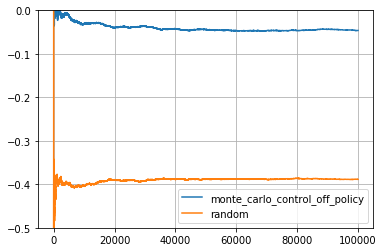

In [27]:
plt.plot(avg_reward, label="monte_carlo_control_off_policy")
plt.plot(avg_reward_random, label="random")
plt.ylim([-0.5, 0])
plt.grid()
_ = plt.legend()

### Алгоритм Q-learning (off-policy TD control):

In [28]:
def q_learning(env, eps=0.5, alpha=0.5, gamma=0.5, num_experiments = NUM_EXPERIMENTS_DEFAULT):
    Q = np.random.rand(*(x.n for x in env.observation_space), env.action_space.n) * 2 - 1
    
    for _ in range(num_experiments):
        observation = env.reset()
        done = False
        while not done:
            a_star = Q[to_index(observation)].argmax()
            ps = np.ones(env.action_space.n) * eps / env.action_space.n
            ps[a_star] = 1 - eps + eps / env.action_space.n
            At = np.random.choice(np.arange(env.action_space.n), p = ps / ps.sum())

            St = observation
            observation, reward, done, info = env.step(At)
            Q[(*to_index(St), At)] += alpha * (reward + gamma * Q[to_index(observation)].max() - Q[(*to_index(St), At)])
    return Q

Построение стратегии off-policy TD control (q_learning) (веса `eps` и `alpha` подобраны эмпирически)

In [29]:
Q_td = q_learning(env, eps=0.5, alpha=0.2, gamma=0.1)

In [30]:
pi = Q_td.argmax(axis=-1)

Прогон стратегии q_learning

In [31]:
avg_reward = check_strategy(env, pi, smooth=False)

Средняя награда: -0.070380
Доля выигрышей: 0.417540
Сумма выигрышей: -7038.0


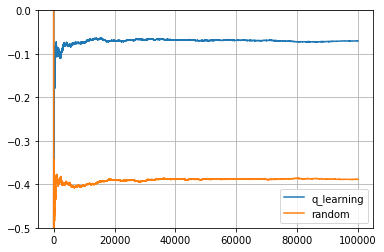

In [33]:
plt.plot(avg_reward, label="q_learning")
plt.plot(avg_reward_random, label="random")
plt.ylim([-0.5, 0])
plt.grid()
_ = plt.legend()

Вывод: хорошо себя показывают алгоритмы Монте-Карло, например off-policy Monte Carlo control имеет лучший результат -4600 на 100К игр). TD алгоритм показывает стаблиьно хуже результат

# Часть вторая, удвоенная

`blackjack.py` - новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки

In [3]:
import blackjack as blackjack_double

In [36]:
env = blackjack_double.BlackjackEnv(natural=True)

### Алгоритм Monte Carlo control with exploring starts

Инициализация и прогон случайной стратегии

In [37]:
pi_random = np.random.randint(env.action_space.n, size=[x.n for x in env.observation_space])
avg_reward_random = check_strategy(env, pi_random, smooth=False)

Средняя награда: -0.545175
Доля выигрышей: 0.287040
Сумма выигрышей: -54517.5


Построение и прогон стратегии monte_carlo_estimation (основано на случайной стратегии)

In [38]:
pi = pi_random.copy()
_ = monte_carlo_estimation(env, pi)

In [39]:
avg_reward = check_strategy(env, pi, smooth=False)

Средняя награда: -0.015200
Доля выигрышей: 0.428090
Сумма выигрышей: -1520.0


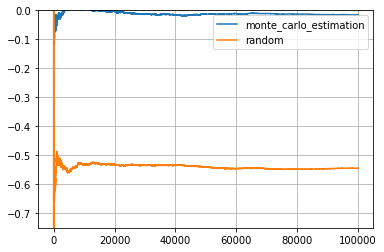

In [40]:
plt.plot(avg_reward, label="monte_carlo_estimation")
plt.plot(avg_reward_random, label="random")
plt.ylim([-0.75, 0])
plt.grid()
_ = plt.legend()

### Алгоритм Q-learning (off-policy TD control):

Построение стратегии off-policy TD control (q_learning) (веса `eps` и `alpha` подобраны на прошлом этапе)

In [41]:
Q_td = q_learning(env, eps=0.5, alpha=0.2, gamma=0.1)

In [42]:
pi = Q_td.argmax(axis=-1)

Прогон стратегии q_learning

In [43]:
avg_reward = check_strategy(env, pi, smooth=False)

Средняя награда: -0.056380
Доля выигрышей: 0.416680
Сумма выигрышей: -5638.0


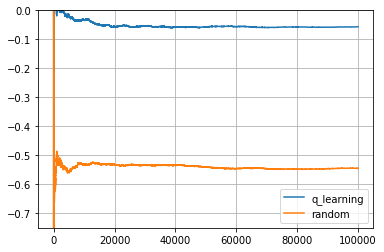

In [44]:
plt.plot(avg_reward, label="q_learning")
plt.plot(avg_reward_random, label="random")
plt.ylim([-0.75, 0])
plt.grid()
_ = plt.legend()

Вывод: с удвоением стратегии все еще проигрывают но заметно меньше (лучший проигрыш -1500 на 100К игр)

# Часть третья, с подсчетом карт

`blackjack_count.py` - новый вариант блекджека на основе окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде

**подсчет карт основан на упрощенной системе подсчёта «Плюс-минус»**

это значит что мы:
- ставим +1 балл за 2, 3, 4, 5, 6 
- ставим -1 балл за 10, В, Д, К, Т
- при этом берем только знак от полученной суммы баллов
- в итоге получаем только 3 состояния вместо 21 (от -10 до 10)
- это уменьшает пространство состояний для более быстрой сходимости

In [45]:
import blackjack_count

In [46]:
from importlib import reload
reload(blackjack_count)

<module 'blackjack_count' from '/Users/aleksei/made/rl/hw1/blackjack_count.py'>

In [47]:
env = blackjack_count.BlackjackEnv(natural=True)

### Алгоритм Monte Carlo control with exploring starts

Инициализация и прогон случайной стратегии

In [48]:
pi_random = np.random.randint(env.action_space.n, size=[x.n for x in env.observation_space])
avg_reward_random = check_strategy(env, pi_random, smooth=False)

Средняя награда: -0.528320
Доля выигрышей: 0.282740
Сумма выигрышей: -52832.0


Построение и прогон стратегии monte_carlo_estimation (основано на случайной стратегии)

In [49]:
pi = pi_random.copy()
_ = monte_carlo_estimation(env, pi)

In [50]:
avg_reward = check_strategy(env, pi, smooth=False)

Средняя награда: -0.025620
Доля выигрышей: 0.426280
Сумма выигрышей: -2562.0


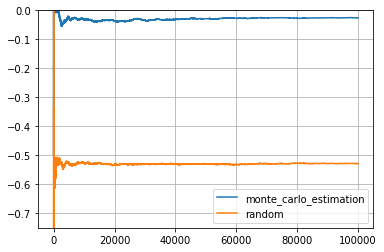

In [51]:
plt.plot(avg_reward, label="monte_carlo_estimation")
plt.plot(avg_reward_random, label="random")
plt.ylim([-0.75, 0])
plt.grid()
_ = plt.legend()

### Алгоритм Q-learning (off-policy TD control):

Построение стратегии off-policy TD control (q_learning) (веса `eps` и `alpha` подобраны на прошлом этапе)

In [52]:
Q_td = q_learning(env, eps=0.5, alpha=0.2, gamma=0.1)

In [53]:
pi = Q_td.argmax(axis=-1)

Прогон стратегии q_learning

In [54]:
avg_reward = check_strategy(env, pi, smooth=False)

Средняя награда: -0.070890
Доля выигрышей: 0.416140
Сумма выигрышей: -7089.0


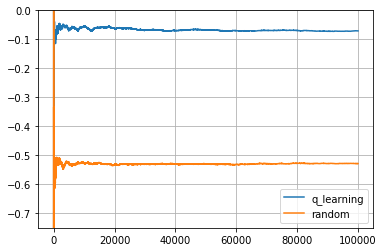

In [55]:
plt.plot(avg_reward, label="q_learning")
plt.plot(avg_reward_random, label="random")
plt.ylim([-0.75, 0])
plt.grid()
_ = plt.legend()

Вывод: такой округленный подсчет себя не оправдал, проигрыш больше чем без подсчета